# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('ggplot')
from sklearn.preprocessing import Imputer 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [6]:
# Identify missing or unknown data values and convert them to NaNs.
pre_missing = azdias.isnull().sum().sum()
pre_missing 

4896838

In [7]:
# parse the encoded string
for i in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[').strip(']').split(',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') 
                          else value for value in missing_or_unknown]
    # mapping the values and replace with Nan
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    # print(missing_or_unknown) to test

In [8]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
after_missing = azdias.isnull().sum().sum()
print('Total Missing Values Before Matching: ', pre_missing)
print('Total Missing Values After Matching: ', after_missing)

Total Missing Values Before Matching:  4896838
Total Missing Values After Matching:  8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of the total missing values and percent on each feature
total = azdias.isnull().sum().sort_values(ascending=False)
percent = (azdias.isnull().sum()/azdias.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['missing_count', 'Percent'])
missing_df.sort_values(by='missing_count',ascending=False, inplace=True)
missing_df

,missing_count,Percent
TITEL_KZ,889061,0.997576
AGER_TYP,685843,0.769554
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
GEBURTSJAHR,392318,0.440203
ALTER_HH,310267,0.348137
REGIOTYP,158064,0.177357
KKK,158064,0.177357
W_KEIT_KIND_HH,147988,0.166051
KBA05_ANTG3,133324,0.149597


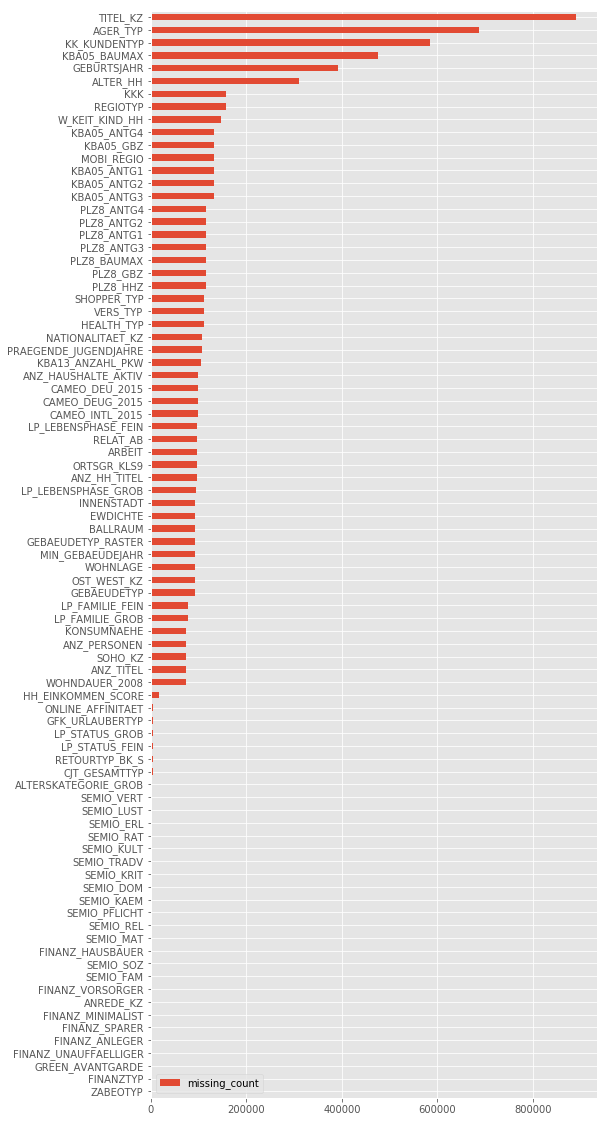

In [12]:
# Investigate patterns in the amount of missing data in each column by visulization
_ = missing_df.plot.barh(y='missing_count',figsize=(8,20))

In [11]:
# identify the features with more than 20% missing values
missing_df[missing_df['Percent'] >= 0.20]

,missing_count,Percent
TITEL_KZ,889061,0.997576
AGER_TYP,685843,0.769554
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
GEBURTSJAHR,392318,0.440203
ALTER_HH,310267,0.348137


In [12]:
# identify the features with more than 10% but under 20% missing values
missing_df[(missing_df['Percent'] > 0.10) & (missing_df['Percent'] < 0.20)]

,missing_count,Percent
REGIOTYP,158064,0.177357
KKK,158064,0.177357
W_KEIT_KIND_HH,147988,0.166051
KBA05_ANTG3,133324,0.149597
KBA05_ANTG2,133324,0.149597
KBA05_ANTG1,133324,0.149597
KBA05_GBZ,133324,0.149597
KBA05_ANTG4,133324,0.149597
MOBI_REGIO,133324,0.149597
PLZ8_GBZ,116515,0.130736


In [13]:
# Remove the outlier columns from the dataset. 
drop_columns = missing_df[missing_df['Percent'] >= 0.20].index.tolist()
drop_columns

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [37]:
# make a copy of original dataframe
azdias_copy = azdias.copy()
# drop the drop_columns
azdias_copy.drop(drop_columns, axis=1, inplace=True)
azdias_copy.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

- From the graph above, we can see that a few features have more than 20% missing values. Many features have more than 10% missing values. It's obvious that the six features with more than 20% missing values are the outliers in terms of the proportion of values that are missing. In particular, 'TITEL_KZ' should be dropped since 99% of the values are missing which makes this feature no valid.
- Thus, I dropped those six features ('TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH') with most missing values from the dataset. 
- Of those other features with around 10% missing values, I will examine them later.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [38]:
# How much data is missing in each row of the dataset?
azdias_copy.isnull().sum(axis=1).value_counts()

0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
dtype: int64

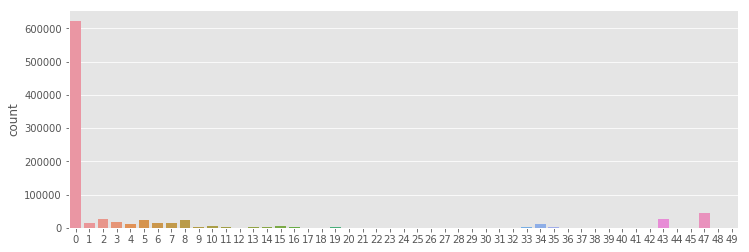

In [39]:
plt.figure(figsize=(12,4))

_ = sns.countplot(azdias_copy.isnull().sum(axis=1))

In [40]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# from the above graph, the threshold should be around 20
missing_low = azdias_copy[azdias_copy.isnull().sum(axis=1) < 20].reset_index(drop=True)
missing_high = azdias_copy[azdias_copy.isnull().sum(axis=1) >= 20].reset_index(drop=True)
missing_low_columns = missing_low.columns.tolist()

In [41]:
print('No. of low missing rows: ', missing_low.shape[0])
print('No. of high missing rows: ', missing_high.shape[0])
print('Columns with low values: ', missing_low_columns)

No. of low missing rows:  797077
No. of high missing rows:  94144
Columns with low values:  ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 

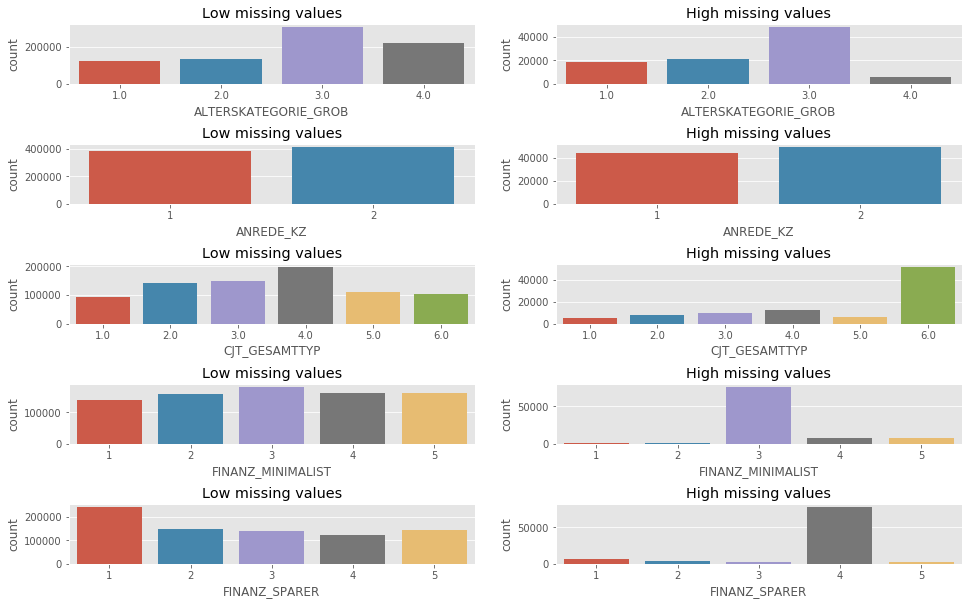

In [42]:
figure, axs = plt.subplots(nrows=5, ncols=2, figsize = (16,20),squeeze=False)
figure.subplots_adjust(hspace =1, wspace=.2, top = 0.5) # tune the subplot layout
for i in range(len(missing_low_columns[:5])):
    sns.countplot(missing_low[missing_low_columns[:5][i]], ax=axs[i][0])
    axs[i][0].set_title('Low missing values')
    sns.countplot(missing_high[missing_low_columns[:5][i]], ax=axs[i][1])
    axs[i][1].set_title('High missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

I performed a similar assessment for the rows of the dataset for identifying the outlier rows. I first divided the features into two categories: missing_low and missing_high with cutting by the 75% distribution threshold. The I made the comparisona among 5 features with the distribution of low missing and high missing. Through the comparisons above, I found that two features ('ALTERSKATEGORIE_GROB' and 'ANREDE_KZ') have the pattern like this：the distributions of non-missing features look similar between the data with many missing values and the data with few missing values. However, the other three features ('CJT_GESAMTTYP', 'FINANZ_MINIMALIST' , 'FINANZ_SPARER') have a different distribution of values between the two split groups. The data with many missing values looks very different from the data with few or no missing values. 

##### Different in distributions: revisit those features later
- 'CJT_GESAMTTYP'
- 'FINANZ_MINIMALIST'
- 'FINANZ_SPARER'

##### Similar in distributions: maybe simply drop the missing values later
- 'ALTERSKATEGORIE_GROB' 
- 'ANREDE_KZ'

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: *categorical, and 'mixed'*.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_v = feat_info[feat_info["type"]=="categorical"]["attribute"]
cat_v = cat_v.tolist()
cat_v

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [45]:
# remove the features that I have dropped already for too many missing values
for v in cat_v:
    if v in drop_columns:
        cat_v.remove(v)
cat_v

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [46]:
# identify the binary categoricals and multi-level categoricals
binary_v = []
multi_v = []
for v in cat_v:
    if (len(azdias_copy[v].unique()) == 2):
        binary_v.append(v)
    elif (len(azdias_copy[v].unique()) > 2):
        multi_v.append(v)
    else:
        print('Check the feature')
        
non_numeric_binary = ['OST_WEST_KZ']

In [53]:
multi_v.remove('OST_WEST_KZ')
print('The binary categoricals are : ', binary_v)
print('The multi-level categoricals are : ', multi_v)
print('Non numeric binary variable is : ', non_numeric_binary)

The binary categoricals are :  ['ANREDE_KZ', 'GREEN_AVANTGARDE']
The multi-level categoricals are :  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Non numeric binary variable is :  ['OST_WEST_KZ']


In [48]:
azdias_copy.ANREDE_KZ.value_counts()

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

In [49]:
azdias_copy.GREEN_AVANTGARDE.value_counts()

0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64

In [50]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_copy.ANREDE_KZ = azdias.ANREDE_KZ.map({2:0,1:1})
azdias_copy.ANREDE_KZ.value_counts()

0    465305
1    425916
Name: ANREDE_KZ, dtype: int64

In [51]:
# encode OST_WEST_KZ in this section since it is a non numeric column
azdias_copy.OST_WEST_KZ.value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [52]:
azdias_copy.OST_WEST_KZ = azdias.OST_WEST_KZ.map({'W':0,'O':1})
azdias_copy.OST_WEST_KZ.value_counts()

0.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

For categorical data, I divided them into three categoricals: numeric_binary, multi-level and one non_numeric_binary. 

I have already removed the outlier columns from the dataset because of the high missing values percentage, now I rencoded the non_numeric_binary 'OST_WEST_KZ' to 0,1. Besides, I also choosed to re-encode the 'ANREDE_KZ' to 0,1 for consistency.  


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [54]:
mixed_v = feat_info[feat_info["type"]=="mixed"]["attribute"]
mixed_v = mixed_v.tolist()
mixed_v

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [55]:
azdias_copy.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [56]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_copy['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE']
azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_copy['PRAEGENDE_JUGENDJAHRE']
mapping_dict_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
mapping_dict_movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
azdias_copy['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_copy['PRAEGENDE_JUGENDJAHRE_DECADE'].map(mapping_dict_decade)
azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_copy['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].map(mapping_dict_movement)

In [57]:
# check the results
print(azdias_copy.PRAEGENDE_JUGENDJAHRE_DECADE.value_counts())
print(azdias_copy.PRAEGENDE_JUGENDJAHRE_MOVEMENT.value_counts())

6.0    231244
4.0    179558
5.0    151770
3.0    116078
2.0     75646
1.0     28761
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
1.0    607832
0.0    175225
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64


In [58]:
# drop the original feature
azdias_copy.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_copy['WEALTH'] = azdias_copy['CAMEO_INTL_2015']
azdias_copy['LIFE_STAGE'] = azdias_copy['CAMEO_INTL_2015']

mapping_dict_wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,
                       '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,
                       '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,
                       '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,
                       '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 1.0}

mapping_dict_lifestage = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,
                          '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,
                          '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,
                          '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,
                          '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}
azdias_copy['WEALTH'] = azdias_copy['WEALTH'].map(mapping_dict_wealth)
azdias_copy['LIFE_STAGE'] = azdias_copy['LIFE_STAGE'].map(mapping_dict_lifestage)

In [60]:
# check the results
print(azdias_copy.WEALTH.value_counts())
print(azdias_copy.LIFE_STAGE.value_counts())

5.0    199627
2.0    190691
4.0    189960
1.0    143398
3.0     68193
Name: WEALTH, dtype: int64
1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: LIFE_STAGE, dtype: int64


In [61]:
# drop the original feature
azdias_copy.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

In [62]:
# Investigate 'WOHNLAGE' and engineer two new variables.

azdias_copy['RURAL'] = azdias_copy['WOHNLAGE']
azdias_copy['NEIGHBORHOOD_QUALITY'] = azdias_copy['WOHNLAGE']

mapping_dict_rural = {1: 0, 2: 0, 3:0, 4:0, 5:0, 7:1, 8:1}
mapping_dict_nq = {1: 1, 2: 2, 3:3, 4:4, 5:5, 7:np.nan, 8:np.nan}
azdias_copy['RURAL'] = azdias_copy['RURAL'].map(mapping_dict_rural)
azdias_copy['NEIGHBORHOOD_QUALITY'] = azdias_copy['NEIGHBORHOOD_QUALITY'].map(mapping_dict_nq)
print(azdias_copy.RURAL.value_counts())
print(azdias_copy.NEIGHBORHOOD_QUALITY.value_counts())

0.0    604332
1.0    186791
Name: RURAL, dtype: int64
3.0    249719
4.0    135973
2.0    100376
5.0     74346
1.0     43918
Name: NEIGHBORHOOD_QUALITY, dtype: int64


In [63]:
# drop the original feature
azdias_copy.drop(['WOHNLAGE'], axis = 1, inplace=True)

In [64]:
drop_mixed = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'] # KBA05_BAUMAX has already droped before
for v in drop_mixed:
    azdias_copy.drop(v, axis=1, inplace=True)

In [65]:
azdias_copy.shape

(891221, 79)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- Of the seven mixed type features, I examined the three of them and engineered each into two new variables. I divided 'PRAEGENDE_JUGENDJAHRE' into DECADE and MOVEMENT based on the two dimensions: an interval-type variable for a decade, and a binary variable for movement. I also engineered 'CAMEO_INTL_2015' into two features: WEALTH and LIFE_STAGE. Besides, I found 'WOHNLAGE' is another feature good to engineer. I first separated the living area into rural or not then created another interval variable for indicating the quality level of the neighborhood in the city and make the rural as NaN. 

- After the processing, I dropped all three original features. I also checked the other four mixed-type features. One was already dropped, and for the other three, I also decided to drop them due to no enough levels and information to engineering those features. Finally, I got total 79 columns. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [66]:
# The dataframe only contains the columns that should be passed to the algorithm functions
# and  remaining missing values will be dealed with in step 2.1.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [67]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    ### Step 1: convert missing value codes into NaNs, ...
    
    # parse the encoded string
    for i in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[').strip(']').split(',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') 
                          else value for value in missing_or_unknown]
    # mapping the values and replace with Nan
    if missing_or_unknown != ['']:
        df = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
        
    ### Step 2: remove selected columns and rows, ...
    drop_columns = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP',
                    'KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df.drop(drop_columns, axis=1, inplace=True)

    ### Step 3: select, re-encode, and engineer column values.
    
    # for categorical features
    df.ANREDE_KZ = df.ANREDE_KZ.map({2:0,1:1})
    df.OST_WEST_KZ = df.OST_WEST_KZ.map({'W':0,'O':1})

    # for mixed-type features
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    mapping_dict_decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    mapping_dict_movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE_DECADE'].map(mapping_dict_decade)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].map(mapping_dict_movement)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    mapping_dict_wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,
                       '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,
                       '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,
                       '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,
                       '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 1.0}
    mapping_dict_lifestage = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,
                          '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,
                          '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,
                          '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,
                          '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}
    df['WEALTH'] = df['WEALTH'].map(mapping_dict_wealth)
    df['LIFE_STAGE'] = df['LIFE_STAGE'].map(mapping_dict_lifestage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df['RURAL'] = df['WOHNLAGE']
    df['NEIGHBORHOOD_QUALITY'] = df['WOHNLAGE']
    mapping_dict_rural = {1: 0, 2: 0, 3:0, 4:0, 5:0, 7:1, 8:1}
    mapping_dict_nq = {1: 1, 2: 2, 3:3, 4:4, 5:5, 7:np.nan, 8:np.nan}
    df['RURAL'] = df['RURAL'].map(mapping_dict_rural)
    df['NEIGHBORHOOD_QUALITY'] = df['NEIGHBORHOOD_QUALITY'].map(mapping_dict_nq)
    df.drop(['WOHNLAGE'], axis = 1, inplace=True)
    
    drop_mixed = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'] 
    for v in drop_mixed:
        df.drop(v, axis=1, inplace=True)
        
    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [68]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_copy.isnull().sum().sum()

5227940

In [69]:
# first drop the two columns discused in 1.13 which is similar in distributions and all the multi_v

drop_columns2 = multi_v + ['ALTERSKATEGORIE_GROB','ANREDE_KZ']
for v in drop_columns2:
    azdias_copy.drop(v, axis = 1, inplace=True)

In [70]:
# impute with the mode 
imputer = Imputer(strategy='most_frequent')
azdias_clean = imputer.fit_transform(azdias_copy)
# convert back to dataframe
azdias_clean_df = pd.DataFrame(azdias_clean)

In [71]:
# check the result
azdias_clean_df.isnull().sum().sum()

0

In [119]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_clean_scaled = scaler.fit_transform(azdias_clean_df)
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled)

In [120]:
azdias_clean_scaled.shape

(891221, 62)

### Discussion 2.1: Apply Feature Scaling

- Before applying feature scaling, the first thing is that all the missing values should be cleaned from the data frame. Thus, I removed the two columns discussed in 1.13 which is similar in distributions but containing many missing values as well as all the multi-level categoricals due to unclear discriptions. Second, I chose to impute all the other missing values with the mode, that is the most frequent value in each column. I used the mode rather than mean or median because most features in this dataset are categorical even in a numerical way. Thus the most frequent value should be the most representative one in the feature. 

- For the actual scaling function, I used StandardScaler to achieve a mean of 0 and a standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [74]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [75]:
# Investigate the variance accounted for by each principal component.
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[  1.67793082e-01   1.21902562e-01   8.64168973e-02   5.50591301e-02
   4.77401841e-02   3.41920334e-02   3.11499467e-02   2.76123290e-02
   2.46962029e-02   2.18210141e-02   2.10107700e-02   2.03228365e-02
   1.92523296e-02   1.80006059e-02   1.72111705e-02   1.67556319e-02
   1.57100325e-02   1.41490010e-02   1.36473121e-02   1.28287717e-02
   1.23554019e-02   1.19802931e-02   1.13137253e-02   1.09110780e-02
   1.04224890e-02   9.88261329e-03   8.87135154e-03   7.48414850e-03
   7.32581621e-03   6.91291008e-03   6.70657392e-03   6.56252213e-03
   6.45648378e-03   6.21165810e-03   5.98747817e-03   5.59975275e-03
   5.18343928e-03   4.98054165e-03   4.66480628e-03   4.50891096e-03
   4.43968685e-03   4.12906878e-03   3.83306610e-03   3.77487569e-03
   3.62638122e-03   3.44407346e-03   3.24549596e-03   3.23687624e-03
   3.01809313e-03   2.97002481e-03   2.78429685e-03   2.71260975e-03
   2.50271203e-03   2.31462324e-03   2.11771968e-03   2.07297875e-03
   1.91759336e-03   1.75492338e-03

Text(0,0.5,'Variance explained Ratio')

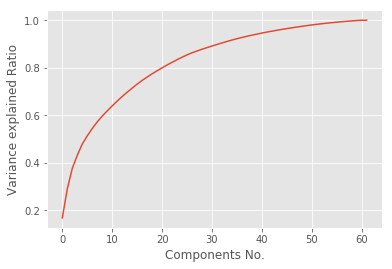

In [76]:
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_.cumsum())
plt.xlabel('Components No.')
plt.ylabel('Variance explained Ratio')

In [121]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=45)
final_features = pca.fit_transform(azdias_clean_scaled)

In [78]:
final_features.shape

(891221, 45)

Text(0,0.5,'Variance explained Ratio')

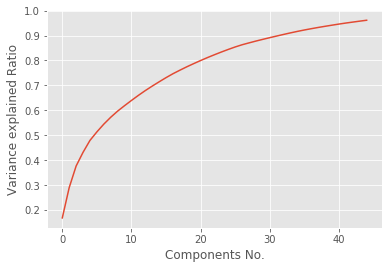

In [79]:
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_.cumsum())
plt.xlabel('Components No.')
plt.ylabel('Variance explained Ratio')

### Discussion 2.2: Perform Dimensionality Reduction

- After the first PCA, I found that around 40 components are a good number to choose to redo the PCA.  Thus I chose the 45 components to redo PCA. From the graph above, it is clear that the 45 components could explain almost 95% of all the variance.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [80]:
pca.components_.shape

(45, 62)

In [81]:
# Reference: original functions provided in the helper_functions.py in course

def do_pca(n_components, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def pca_results(full_dataset, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
    
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


In [82]:
pca, X_pca = do_pca(4, azdias_clean_scaled)

,Explained Variance,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,WEALTH,LIFE_STAGE,RURAL,NEIGHBORHOOD_QUALITY
Dimension 1,0.1678,-0.2135,0.1532,-0.1138,0.0889,0.0971,0.1523,-0.1166,0.0564,-0.0181,...,-0.1695,0.1577,0.1993,0.1367,0.1176,0.1166,0.2005,-0.1429,-0.1587,0.0895
Dimension 2,0.1219,0.0826,-0.2656,0.2568,-0.2485,-0.2550,0.1228,0.0110,-0.0841,0.1818,...,-0.0745,0.0593,0.1173,0.0791,-0.2717,-0.0110,0.0193,0.0320,-0.0708,0.0165
Dimension 3,0.0864,0.0834,-0.0498,0.0204,-0.1705,-0.0951,-0.0283,0.0785,-0.0753,0.0537,...,-0.0395,0.0016,0.0756,0.0425,-0.0698,-0.0785,-0.0348,0.0486,-0.0120,0.0260
Dimension 4,0.0551,0.0034,0.0311,-0.0611,-0.0763,0.0695,-0.0732,0.3836,0.0006,-0.0448,...,0.0421,0.0380,0.2415,0.0950,0.0510,-0.3836,-0.1336,0.1013,-0.2047,-0.1496


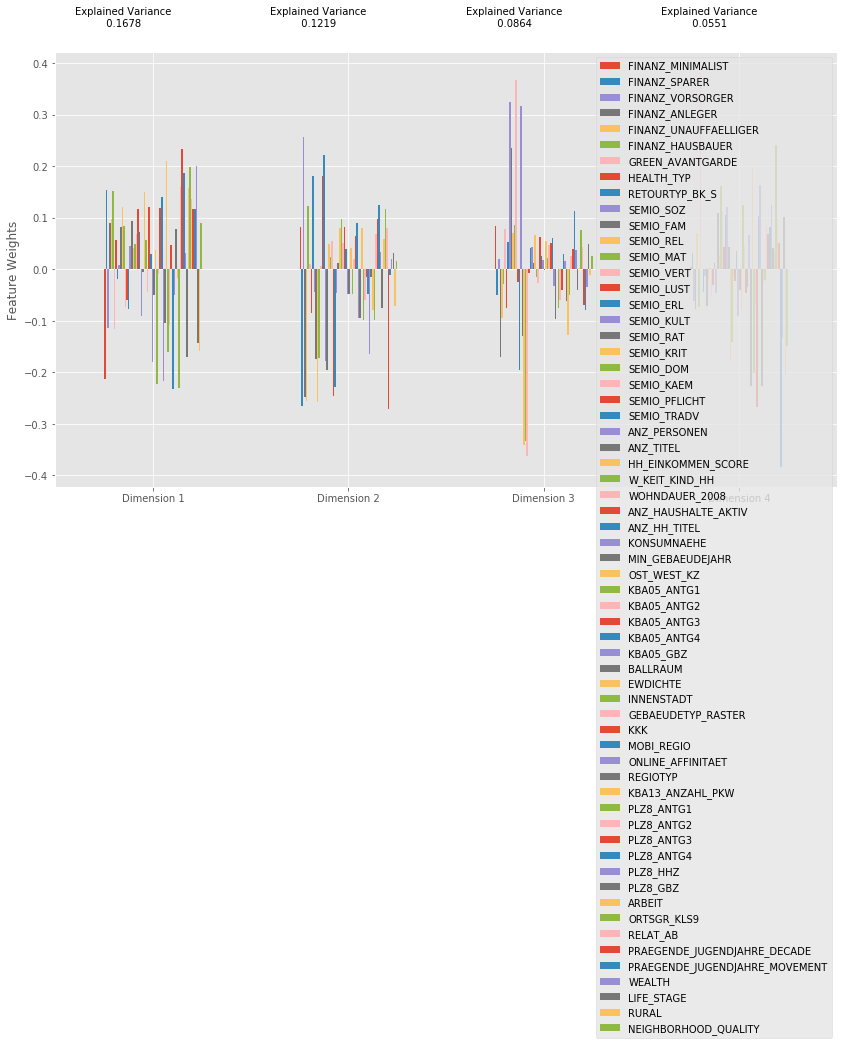

In [83]:
pca_results(azdias_copy, pca)

In [84]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_1 = pd.DataFrame(pca.components_, columns=list(azdias_copy.columns)).iloc[0].sort_values(ascending=False)
print(weight_1)

PLZ8_ANTG3                        0.233226
EWDICHTE                          0.210836
WEALTH                            0.200454
ORTSGR_KLS9                       0.199288
PLZ8_ANTG4                        0.186127
PLZ8_ANTG2                        0.159956
ARBEIT                            0.157676
FINANZ_SPARER                     0.153154
FINANZ_HAUSBAUER                  0.152348
HH_EINKOMMEN_SCORE                0.150732
KBA05_ANTG4                       0.140160
RELAT_AB                          0.136694
ANZ_HAUSHALTE_AKTIV               0.121134
SEMIO_REL                         0.120528
KBA05_ANTG3                       0.118996
PRAEGENDE_JUGENDJAHRE_DECADE      0.117586
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.116646
SEMIO_PFLICHT                     0.116332
FINANZ_UNAUFFAELLIGER             0.097107
SEMIO_RAT                         0.093645
NEIGHBORHOOD_QUALITY              0.089459
FINANZ_ANLEGER                    0.088936
SEMIO_MAT                         0.083621
SEMIO_FAM  

In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_2 = pd.DataFrame(pca.components_, columns=list(azdias_copy.columns)).iloc[1].sort_values(ascending=False)
print(weight_2)

FINANZ_VORSORGER                  0.256825
SEMIO_ERL                         0.221783
RETOURTYP_BK_S                    0.181775
SEMIO_LUST                        0.180315
PLZ8_ANTG4                        0.124669
FINANZ_HAUSBAUER                  0.122768
ORTSGR_KLS9                       0.117272
W_KEIT_KIND_HH                    0.098108
PLZ8_ANTG3                        0.097845
KBA05_ANTG4                       0.090579
ANZ_HAUSHALTE_AKTIV               0.082760
FINANZ_MINIMALIST                 0.082615
HH_EINKOMMEN_SCORE                0.080199
EWDICHTE                          0.079510
RELAT_AB                          0.079113
PLZ8_ANTG2                        0.068976
KBA05_ANTG3                       0.064757
ARBEIT                            0.059275
SEMIO_KAEM                        0.054652
WOHNDAUER_2008                    0.051785
SEMIO_KRIT                        0.048109
OST_WEST_KZ                       0.042123
ANZ_HH_TITEL                      0.040145
PLZ8_HHZ   

In [86]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_3 = pd.DataFrame(pca.components_, columns=list(azdias_copy.columns)).iloc[2].sort_values(ascending=False)
print(weight_3)


SEMIO_VERT                        0.368006
SEMIO_SOZ                         0.325145
SEMIO_KULT                        0.316766
SEMIO_FAM                         0.235375
PLZ8_ANTG4                        0.113948
SEMIO_MAT                         0.086391
FINANZ_MINIMALIST                 0.083369
GREEN_AVANTGARDE                  0.078530
ORTSGR_KLS9                       0.075567
SEMIO_REL                         0.070046
HH_EINKOMMEN_SCORE                0.065819
ANZ_HAUSHALTE_AKTIV               0.062470
KBA05_ANTG4                       0.061370
OST_WEST_KZ                       0.055539
RETOURTYP_BK_S                    0.053677
KBA05_ANTG3                       0.051218
LIFE_STAGE                        0.048614
KBA05_ANTG2                       0.047518
ANZ_PERSONEN                      0.042994
RELAT_AB                          0.042485
SEMIO_TRADV                       0.041532
PLZ8_ANTG3                        0.039979
PLZ8_HHZ                          0.036923
MOBI_REGIO 

### Discussion 2.3: Interpret Principal Components

- To investigate the features, I mapped each weight to their corresponding feature name, then sort the features according to weight by the graphs, which gives us a general idea of the components and their contributions. However, due to the high number of features, it's not very straightforward in the visualization graph. Then I simply calculated them and displayed as a decreasing order list.  

### The first principle component: 

Positively weights: 
- PLZ8_ANTG3 (0.233226): number of 6-10 family houses in particular region (middle-size family)
- EWDICHTE (0.210836): density of households per square kilometer
- WEALTH (0.200454): wealth levels of households

Negatively weights:

- FINANZ_MINIMALIST (-0.213537): financial typology (low financial interest)
- KBA05_GBZ (-0.216709): number of building in the microcell
- KBA05_ANTG1 (-0.222917): number of 1-2 family houses in the microcell
- PLZ8_ANTG1 (-0.229659): number of 1-2 family houses in particular region
- MOBI_REGIO (-0.232471): movement patterns

The first principle component is mainly related to family size and household density. The financial typology and wealth of the household also make an impact on that. 

### The second principle component:

Positively weights: 
- FINANZ_VORSORGER (0.256825): financial typology (be prepared)
- SEMIO_ERL (0.221783): Personality typology (event-oriented)

Negatively weights:
- SEMIO_TRADV (-0.229144): Personality typology (traditional-minded)
- SEMIO_PFLICHT (-0.246278): Personality typology (dutiful)
- FINANZ_ANLEGER (-0.248468):  financial typology (investor)
- FINANZ_UNAUFFAELLIGER (-0.255002):  financial typology (inconspicious)
- SEMIO_REL (-0.258297): Personality typology (religious)
- FINANZ_SPARER (-0.265627):  financial typology (money-saver)
- PRAEGENDE_JUGENDJAHRE_DECADE (-0.271675): dominating movement of person's youth

The second principal component is about financial typology and personality typology. The people with a be-prepared financial mindset and event-oriented personality have positive relations.


### The third principle component:

Positively weights: 
- SEMIO_VERT (0.368006): Personality typology (dreamful)
- SEMIO_SOZ (0.325145): Personality typology (socially-minded)
- SEMIO_KULT (0.316766): Personality typology (cultural-minded)
- SEMIO_FAM (0.235375): Personality typology (family-minded)

Negatively weights:
- SEMIO_DOM (-0.333820): Personality typology (dominated-minded)
- SEMIO_KRIT (-0.341425): Personality typology (critical-minded)
- SEMIO_KAEM (-0.362792): Personality typology (combative-minded)


The third principal component is all about a person's personality typology. People with more social, cultural, dreamful personalities indicate positive values, while people with more dominated, critical and combative mindset have negative values. 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Running time is :  41.29


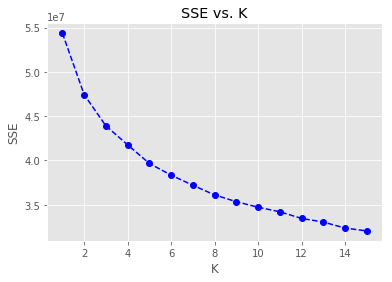

In [63]:
# Reference: original function provided in the changing_k session in course

start_time = time.time()

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,16))

for center in centers:
    scores.append(get_kmeans_score(azdias_clean_scaled, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')

print('Running time is : ', np.round(((time.time() - start_time) / 60), 3))

In [87]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# selected a number of 12 in n_clusters to use

kmeans = KMeans(n_clusters=12).fit(final_features)
predict = kmeans.predict(final_features)

### Discussion 3.1: Apply Clustering to General Population

- In order to find the right number to segment the population, I used a plot to see the relationship between the number of clusters and score related to the model fit. From the graph, it seems that the number between 10 and 14 is the elbow. Thus, I decided to choose 12 as the clustering number.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [122]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [123]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers = clean_data(customers)
df_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,WEALTH,LIFE_STAGE,RURAL,NEIGHBORHOOD_QUALITY
0,4,1,5.0,5,1,5,1,2,2,2,...,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0,1.0,NaN
1,4,1,NaN,5,1,5,1,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,0,2.0,5,1,5,1,4,4,2,...,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0,0.0,2.0
3,4,1,2.0,5,1,5,2,1,2,6,...,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0,1.0,NaN
4,3,1,6.0,3,1,4,4,5,2,2,...,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0,0.0,3.0


In [124]:
# clean this dataset of all NaN values according to the same process in azdias_clean
# drop the columns
for v in drop_columns2:
    df_customers.drop(v, axis = 1, inplace=True)   
# impute with the mode 
imputer = Imputer(strategy='most_frequent')
df_customers_clean = imputer.transform(df_customers)
# convert back to dataframe
df_customers_clean= pd.DataFrame(df_customers_clean)
df_customers_clean.isnull().sum().sum()

0

In [125]:
# Standardize
df_customers_scaled = scaler.transform(df_customers_clean)
df_customers_scaled = pd.DataFrame(df_customers_scaled)

In [126]:
df_customers_scaled.shape

(191652, 62)

In [127]:
azdias_clean_scaled.shape

(891221, 62)

In [128]:
# the df_customers_scaled shared the same number of columns with azdias one
# PCA transformation
customers_pca = pca.transform(df_customers_scaled)
customers_pca.shape

(191652, 45)

In [129]:
# Predict using Kmeans 
predict_customers = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General')

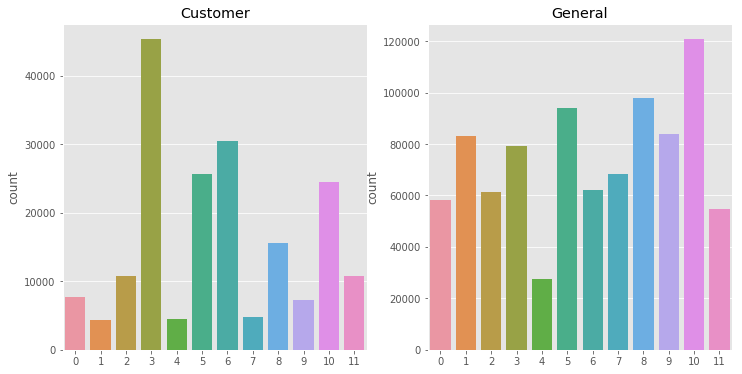

In [130]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
figure.subplots_adjust(hspace = 1, wspace=.2) # tune the subplot layout

sns.countplot(predict_customers, ax=axs[0])
axs[0].set_title('Customer')
sns.countplot(predict, ax=axs[1])
axs[1].set_title('General')

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [131]:
# create an inverse transform
centroid_3 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[3]))

In [132]:
centroid_3 = pd.DataFrame(pca.components_, columns=list(df_customers.columns)).iloc[3].sort_values(ascending=False)
print(centroid_3)

GREEN_AVANTGARDE                  0.383651
ORTSGR_KLS9                       0.241482
EWDICHTE                          0.195608
ONLINE_AFFINITAET                 0.162855
SEMIO_DOM                         0.161126
KBA05_ANTG1                       0.124829
PLZ8_HHZ                          0.124099
ANZ_PERSONEN                      0.120019
SEMIO_KAEM                        0.113633
SEMIO_RAT                         0.108566
SEMIO_TRADV                       0.104804
MOBI_REGIO                        0.102882
LIFE_STAGE                        0.101341
RELAT_AB                          0.095000
PLZ8_ANTG2                        0.084712
PLZ8_ANTG4                        0.082179
FINANZ_UNAUFFAELLIGER             0.069506
PLZ8_ANTG3                        0.067590
KBA05_GBZ                         0.066623
PRAEGENDE_JUGENDJAHRE_DECADE      0.050962
KBA05_ANTG2                       0.045373
ANZ_TITEL                         0.043648
SEMIO_PFLICHT                     0.042947
PLZ8_GBZ   

In [133]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_1 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[1]))
centroid_1 = pd.DataFrame(pca.components_, columns=list(df_customers.columns)).iloc[1].sort_values(ascending=False)
print(centroid_1)

FINANZ_VORSORGER                  0.256825
SEMIO_ERL                         0.221783
RETOURTYP_BK_S                    0.181775
SEMIO_LUST                        0.180315
PLZ8_ANTG4                        0.124669
FINANZ_HAUSBAUER                  0.122768
ORTSGR_KLS9                       0.117272
W_KEIT_KIND_HH                    0.098108
PLZ8_ANTG3                        0.097845
KBA05_ANTG4                       0.090579
ANZ_HAUSHALTE_AKTIV               0.082760
FINANZ_MINIMALIST                 0.082615
HH_EINKOMMEN_SCORE                0.080199
EWDICHTE                          0.079510
RELAT_AB                          0.079113
PLZ8_ANTG2                        0.068976
KBA05_ANTG3                       0.064757
ARBEIT                            0.059275
SEMIO_KAEM                        0.054652
WOHNDAUER_2008                    0.051785
SEMIO_KRIT                        0.048109
OST_WEST_KZ                       0.042123
ANZ_HH_TITEL                      0.040145
PLZ8_HHZ   

In [134]:
centroid_9 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[9]))
centroid_9 = pd.DataFrame(pca.components_, columns=list(df_customers.columns)).iloc[9].sort_values(ascending=False)
print(centroid_9)

ANZ_PERSONEN                      0.269576
WOHNDAUER_2008                    0.237728
SEMIO_LUST                        0.216613
FINANZ_ANLEGER                    0.203279
FINANZ_SPARER                     0.165807
BALLRAUM                          0.158633
PRAEGENDE_JUGENDJAHRE_DECADE      0.140904
WEALTH                            0.139205
FINANZ_HAUSBAUER                  0.135966
HEALTH_TYP                        0.127773
INNENSTADT                        0.120925
ANZ_HH_TITEL                      0.109424
ANZ_TITEL                         0.103522
MOBI_REGIO                        0.103004
ONLINE_AFFINITAET                 0.096476
KBA05_ANTG1                       0.092618
SEMIO_SOZ                         0.080773
FINANZ_UNAUFFAELLIGER             0.080373
GREEN_AVANTGARDE                  0.069793
KBA05_ANTG2                       0.068116
OST_WEST_KZ                       0.067495
RURAL                             0.063086
PLZ8_ANTG4                        0.058444
ANZ_HAUSHAL

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Overrepresentative:
 
##### Cluster 3: 
- I picked three highest features that had positive/negative relations and the values are beyond 0.20 to explain.
- 'GREEN_AVANTGARDE': Membership in environmental sustainability as part of youth (0.38)
- 'ORTSGR_KLS9': Size of community (0.24)
- 'PRAEGENDE_JUGENDJAHRE_MOVEMENT': Dominating movement of person's youth (avantgarde vs. mainstream) (-0.38)

It seems that the company targeted more on the people who were participated and interested in environmental issues during a person's youth and also with the avantgarde-type dominating movement of a person's youth. Besides, the popular cluster relates to the people who live in a large size of a community as well. Thus, they are relatively popular with the mail-order company but overrepresented in general.

#### Underrepresentative: 

##### Cluster 1:
- I picked four highest features that had positive/negative relations and the values are beyond 0.20 to explain.
- 'FINANZ_VORSORGER': Financial typology (be prepared) (0.26)
- 'SEMIO_ERL': Personality typology (event-oriented) (0.22)
- 'PRAEGENDE_JUGENDJAHRE_DECADE': an interval-type variable for decade (-0.27)
- 'FINANZ_SPARER': Financial typology (money-saver) (-0.26)

It seems that the company targeted less on the people who are event-oriented personality and also prepared in the financial area. Accordingly, older people with money-saver habit are a negative impact here. That is useful to know because those type of young people is often open to the world and more interest in consumption, but it underrepresented here. 

##### Cluster  9: 
- I also picked the most impact features with positive/negative relations here.
- 'ANZ_PERSONEN': Number of adults in a household (0.27)
- 'WOHNDAUER_2008': Length of residence (0.24)
- 'MIN_GEBAEUDEJAHR': first year building was mentioned in the database (lower number means longer existed building) (-0.41)

It seems that people who live in a family with more adults for an extended period in the customer population are the target for underrepresentation. Among those features, the most substantial impact is the length of residence. It's a beneficial finding some under representative clusters since the mail-order company possibly ignore this type of potential customers. 



### Reference

Udacity Unsupervised Learning Course and practices

- https://classroom.udacity.com/nanodegrees/nd025/parts/31adfeff-4f9d-4a6e-9856-629feab109be

PCA and Interpret Principal Components

- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.